## Importing libraries

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Pytorch
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import statsmodels
import sklearn
from sklearn.metrics import mean_squared_error
import plotly.express as px
import os
import random
import pandas as pd
import plotly.graph_objects as go
import joypy
import time
from matplotlib import pyplot
from disaggregation.models.transformer.model import TransformerTimeSeries
from disaggregation.utils.dataset import DisaggregationSet
from disaggregation.utils.training import batch_train, batch_val

from numpy.lib.function_base import average

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


## Get the train and test sets
In this example we will assume a simple scenario containing the aggregated data of two users and we will test if the model can in fact desegregate the traffic.

In [56]:
houses_df = [pd.read_csv(f'house{i}.csv') for i in range(1,4)]
for i, df in enumerate(houses_df):
    if 'mains_1' in list(df.columns):
        houses_df[i] = houses_df[i].rename(columns={"mains_1":"mains"})
    else:
        houses_df[i] = houses_df[i].rename(columns={"mains_2":"mains"})

    houses_df[i] = houses_df[i].rename(columns={"Unnamed: 0" : "date"})
    houses_df[i]['date']=pd.to_datetime(houses_df[i]['date'])
    houses_df[i] = houses_df[i].resample('1Min',on='date').mean().dropna()
    houses_df[i] = houses_df[i].reset_index()

In [57]:
plot_df = houses_df[0]
fig = px.line(plot_df, x='date', y=['mains', 'microwave'])
fig.show()

In [62]:
# dataset dataframe
test_sz = 0.3

def generate_simple_set(houses_df,  test_sz = 0.2):
      datasets = []
      for house in houses_df:
            label = house['microwave'].to_numpy()
            agg = house['mains'].to_numpy()
            x_train, x_test, y_train, y_test = train_test_split(agg, label,
                                                                test_size=test_sz,
                                                                shuffle=False)

            # Feature and Label scaling
            feat_scaler = MinMaxScaler()
            feat_scaler.fit(x_train.reshape(len(x_train), 1))

            x_train = feat_scaler.transform(x_train.reshape(len(x_train), 1))
            x_test = feat_scaler.transform(x_test.reshape(len(x_test), 1))

            # label_scaler = MinMaxScaler()
            # label_scaler.fit(y_train)

            # y_train = feat_scaler.transform(y_train)
            # y_test = feat_scaler.transform(y_test)

            df = {'x_train': x_train.flatten(),
                  'x_test': x_test.flatten(),
                  'y_train': y_train,
                  'y_test': y_test,
                  'feat_scaler': feat_scaler,
                  # 'label_scaler': label_scaler
                  }
            datasets.append(df)
      return datasets

datasets = generate_simple_set(houses_df, test_sz = test_sz)

In [63]:
def rolling_window_mtx(x, window_size):
    """Compute all overlapping (rolling) observation windows over a vector
        and return a matrix

    Args:
        x           : observation vector that is supposed to be split into
                        overlapping windows
        window_size : the target window size

    Returns:

        Window matrix with all windows as rows. That is, if n_windows is the
        number of windows, the result has dimensions:

        (n_windows, window_size)

    """
    if window_size < 1:
        raise ValueError("`window_size` must be at least 1.")
    if window_size > x.shape[-1]:
        raise ValueError("`window_size` is too long.")

    shape = x.shape[:-1] + (x.shape[-1] - window_size + 1, window_size)
    strides = x.strides + (x.strides[-1],)

    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [66]:
win_size = 20
n_signals = 2
train_index = np.arange(len(datasets[0]['x_train']))
x_train = rolling_window_mtx(datasets[0]['x_train'], win_size)
x_train_i = rolling_window_mtx(train_index, win_size)
x_test = rolling_window_mtx(datasets[0]['x_test'],win_size)

In [73]:
x_train_i[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [76]:
y_train_i = rolling_window_mtx(train_index[win_size-1:], 1)
y_train = rolling_window_mtx(datasets[0]['y_train'][win_size-1:], 1)
y_train_i = rolling_window_mtx(train_index[win_size-1:], 1)
y_test = rolling_window_mtx(datasets[0]['y_test'][win_size-1:], 1)

In [79]:
y_train_i[0]

array([19])

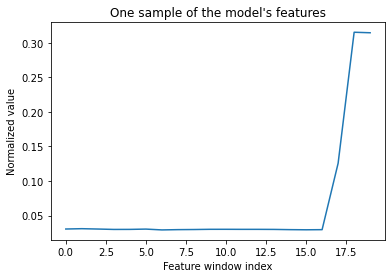

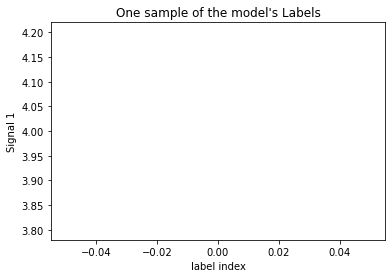

In [81]:
plt.plot(x_train[0], label='features')
plt.ylabel('Normalized value')
plt.xlabel('Feature window index')
plt.title("One sample of the model's features")
plt.show()

plt.plot(y_train[0], label='labels 0')
plt.ylabel('Signal 1')
plt.xlabel('label index')
plt.title("One sample of the model's Labels")
plt.show()

## Transformer network

In [32]:
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [33]:
seed_torch(seed=234123)
# seed_torch(seed=42)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = TransformerTimeSeries(device, dropout=0, d_model=64,
                              encoder_mask=False,
                              nhead=2,
                              output_vector_sz=2,
                              n_encoder_time_steps=win_size,
                              n_enc_layers=1,
                             ).to(device)

criterion = nn.MSELoss()
lr = 0.0005
batch_size= 60
epochs = 30
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

Using device: cuda


In [35]:
train_set = DisaggregationSet(x_train, y_train)
test_set  = DisaggregationSet(x_test, y_test)

train_loader = DataLoader(train_set,
                          batch_size=batch_size,
                          shuffle=False,)
test_loader = DataLoader(test_set,
                          batch_size=batch_size,
                          shuffle=False)

In [36]:
src, true_target = next(iter(train_loader))
src = src.to(torch.float32)
src = src.to(device)
src.shape

torch.Size([60, 60, 1])

In [37]:
out = model(src) 
out.shape

torch.Size([60, 60, 2])

In [38]:
loss = []
val_loss = []
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    epoch_loss = batch_train(model, epoch, batch_size, train_loader, criterion, optimizer, scheduler,
                             y_train.shape[0],
                             device)
    val_epoch_loss = batch_val(model, test_loader,
                               criterion, device)
    loss.append(epoch_loss)
    val_loss.append(val_epoch_loss)
    scheduler.step()


/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:369: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



| epoch   1 |     6/   32 batches | lr 0.000500 | 70.51 ms | loss 14.95685
| epoch   1 |    12/   32 batches | lr 0.000500 | 30.64 ms | loss 12.24198
| epoch   1 |    18/   32 batches | lr 0.000500 | 35.11 ms | loss 13.36275
| epoch   1 |    24/   32 batches | lr 0.000500 | 32.83 ms | loss 12.00978
| epoch   1 |    30/   32 batches | lr 0.000500 | 34.72 ms | loss 11.90783
| epoch   2 |     6/   32 batches | lr 0.000480 | 39.38 ms | loss 11.33977
| epoch   2 |    12/   32 batches | lr 0.000480 | 33.15 ms | loss 9.53614
| epoch   2 |    18/   32 batches | lr 0.000480 | 32.03 ms | loss 10.44550
| epoch   2 |    24/   32 batches | lr 0.000480 | 32.80 ms | loss 9.60711
| epoch   2 |    30/   32 batches | lr 0.000480 | 33.75 ms | loss 9.54684
| epoch   3 |     6/   32 batches | lr 0.000471 | 38.78 ms | loss 9.12837
| epoch   3 |    12/   32 batches | lr 0.000471 | 34.15 ms | loss 8.22758
| epoch   3 |    18/   32 batches | lr 0.000471 | 32.99 ms | loss 9.35197
| epoch   3 |    24/   32 batch

In [39]:
plot_df ={'loss': loss,
          'val_loss': val_loss,
         'epochs': np.arange(len(loss))}

fig = px.line(plot_df, x='epochs', y=['loss', 'val_loss'])
fig.show()

In [40]:
src, true_target = next(iter(train_loader))
src = Variable(torch.Tensor(src.float())).to(device)

output = model(src)
output.shape

torch.Size([60, 60, 2])

In [41]:
true_target.shape

torch.Size([60, 60, 2])

In [42]:
src, true_target = next(iter(test_set))
src.shape

(60, 1)

In [43]:
model.eval()
src, true_target = next(iter(test_set))
src = torch.tensor(np.array([src]))
src = src.to(torch.float32)
src = src.to(device)
output = model(src).cpu()
output = output.detach().numpy().reshape(output.shape[1], 2)

In [44]:
output.shape

(60, 2)

In [45]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1,
                    subplot_titles=[f'Signal {i}' for i in range(n_signals)],
                    x_title='Time steps',
                    y_title='Signal Magnitude')
fig.add_trace(go.Scatter(
        y=src.cpu().detach().numpy().flatten(),
        mode='lines+markers',
        name=f'Aggregated Signal'),
        row=1, col=1)

for i in range(n_signals):
    fig.add_trace(go.Scatter(
        y=output[:, i],
        mode='lines+markers',
        name=f'Signal {i+1} estimation'),
        row=i+2, col=1)
    fig.add_trace(go.Scatter(
        y=true_target[:, i],
        mode='lines+markers',
        name=f'Signal {i+1} Label'),
        row=i+2, col=1)

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Entry and Desaggregated signals estimation',
)

fig.update_layout(
    legend=dict(
        x=1,
        y=1,
        traceorder="reversed",
        font=dict(
            size=15,
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)

fig.show()

In [46]:
mean_squared_error(output[:, 1], true_target[:,1])

9.939796184565274

In [47]:
mean_squared_error(output[:, 0], true_target[:,0])

9.63377418421546

In [48]:
attention_weights = model.encoder_attention(src, layer_idx=0)[0][0]
attention_weights = attention_weights.cpu().detach().numpy()
attention_weights.shape

(2, 60, 60)

In [49]:

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=[f'Attention head {i}' for i in range(attention_weights.shape[0])],
                    x_title='Input time steps',
                    y_title='Output time steps')

for i, head_attn in enumerate(attention_weights):
    head_attn = head_attn/np.max(head_attn.flatten())
    fig.add_trace(
        go.Heatmap(z=head_attn), row=1, col=i+1)

fig.update_layout(
    autosize=False,
    width=900,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Attention matrix per head',
)
fig['layout']['yaxis']['autorange'] = "reversed"
fig['layout']['yaxis2']['autorange'] = "reversed"
fig.update_annotations(font=dict(
    family="Times new Roman",
    size=20))
fig.show()

In [50]:
from scipy.signal import find_peaks
# indices = find_peaks(result_attn)[0]

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=[f'Attention head {i}' for i in range(attention_weights.shape[0])],
                    x_title='Input time steps',
                    y_title='Summed attention')

all_peaks_indices = np.array([])
for i, head_attn in enumerate(attention_weights):
    head_attn = head_attn/np.max(head_attn.flatten())
    result_attn = head_attn.sum(axis=0)
    indices = find_peaks(result_attn, distance = 15,)[0]
    fig.add_trace(go.Scatter(
    y=result_attn,
    mode='lines+markers',
    name=f'Head {i}'),
    row=1, col=i+1)

    for idx in indices:
        xref = f'x{i+1}' if i > 0 else 'x'
        yref = f'y{i+1}' if i > 0 else 'y'
        fig.add_annotation(
                x=idx,
                y=result_attn[idx],
                xref=xref,
                yref=yref,
                text=f"<b>Attention Peak at<b> {idx}",
                showarrow=True,
                font=dict(
                    size=16,
                    ),
                align="center",
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="Red",
                ax=-30,
                ay=-30,
                bordercolor="Black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=0.8
                )
    all_peaks_indices = np.concatenate((all_peaks_indices, indices), axis=0)

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Summed attention per head',

)
# fig = px.line(plot_df, x='entry_index', y=['entry'])
fig.show()

In [51]:
all_peaks_indices = all_peaks_indices.astype(np.int32)

In [52]:
entry = src.cpu().view(-1).detach().numpy()
entry.shape

(60,)

In [53]:
entry = src.cpu().view(-1).detach().numpy()

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=entry,
    mode='lines+markers',
    name='entries'
))
for i in all_peaks_indices:
    fig.add_annotation(
            x=i,
            y=entry[i],
            xref="x",
            yref="y",
            text=f"<b>Attention Peak at<b> {i}",
            showarrow=True,
            font=dict(
                size=16,
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="Red",
            ax=20,
            ay=+40,
            bordercolor="Black",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ff7f0e",
            opacity=0.8
            )
fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    yaxis=dict(
        title_text="Entries",
    ),
    xaxis=dict(title_text="Index"),
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn'
)
# fig = px.line(plot_df, x='entry_index', y=['entry'])
fig.show()

# plot_df ={'entry_index': np.arange(entries.shape[1]),
#           'entry': src.cpu().view(-1).detach().numpy()}

# fig = px.line(plot_df, x='entry_index', y=['entry'], width=600, height=600)
# fig.show()

In [58]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=[f'Attention head {i}' for i in range(attention_weights.shape[0])],
                    x_title='Time steps',
                    y_title='Input')

for i, head_attn in enumerate(attention_weights):
    head_attn = head_attn/np.max(head_attn.flatten())
    result_attn = head_attn.sum(axis=0)
    result_attn = result_attn/np.max(result_attn)
    result_attn_mtx = np.array([result_attn for i in range(len(result_attn))])
    fig.add_trace(go.Scatter(
    y=entry,
    mode='markers+lines',
    name='entries',
    line=dict(color="Blue"),
    marker=dict(color=result_attn, colorscale='Inferno', size=10,
        showscale=True if i> 0 else False,)
), row=1, col=i+1)

fig.update_annotations(font=dict(
    family="Times new Roman",
    size=20))
fig.update_layout(showlegend=False)
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    title='Inputs with the Summed attention head 1',
    template='plotly_dark'
)
fig.show()